<img src="https://bit.ly/2VnXWr2" width="100" align="left">

# Final project: NLP to predict Myers-Briggs Personality Type

## Imports

In [195]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import umap.plot
from yellowbrick.text import UMAPVisualizer

# Data Visualization for text
from PIL import Image
from os import path
import os
import random
from wordcloud import WordCloud, STOPWORDS

# Text Processing
import re
import itertools
import spacy
import string
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from collections import Counter

# Machine Learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import sklearn.cluster as cluster
# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

# Work with pickles
import pickle

# Fix imbalance
from imblearn.under_sampling import InstanceHardnessThreshold

# Model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

pd.set_option("display.max_column", None)

## 2. Data preprocessing

In [175]:
mbti_df = pd.read_csv("../your-project/data/mbti_1.csv")

### Cleaning text

In [3]:
type = ["type"]
posts = ["posts"]
columns = [*type, *posts]

In [4]:
mbti_df_raw = mbti_df
mbti_df_raw[type] = mbti_df[type].fillna("")
mbti_df_raw[posts] = mbti_df[posts].fillna("")
mbti_df_raw.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


#### Declare preprocessing functions

##### Cleaning functions

In [5]:
def clean_url(str_text_raw):
    """This function eliminate a string URL in a given text"""
    str_text = re.sub("url_\S+", "", str_text_raw)
    str_text = re.sub("email_\S+", "", str_text)
    str_text = re.sub("phone_\S+", "", str_text)
    return(re.sub("http[s]?://\S+", "", str_text))
    
def clean_punctuation(str_text_raw):
    """This function replace some of the troublemaker puntuation elements in a given text"""
    return(re.sub("[$\(\)/|{|\}#~\[\]^#;:!?¿]", " ", str_text_raw))

def clean_unicode(str_text_raw):
    """This function eliminate non-unicode text"""
    str_text = re.sub("&amp;", "", str_text_raw)
    return(re.sub(r"[^\x00-\x7F]+"," ", str_text))
                      
def clean_dot_words(str_text_raw):
    """This function replace dots between words"""
    return(re.sub(r"(\w+)\.+(\w+)", r"\1 \2",str_text_raw))

def clean_text(str_text_raw):
    """This function sets the text to lowercase and applies previous cleaning functions """
    str_text = str_text_raw.lower()
    str_text = clean_dot_words(clean_punctuation(clean_unicode(clean_url(str_text))))
    return(str_text)

##### Tokenization and lemmatization functions

In [6]:
tokens_to_drop=["+"]

def string_to_token(string, str_pickle = None):
    """
    This function takes a sentence and returns the list of tokens and all their information
    * Text: The original text of the lemma.
    * Lemma: Lemma.
    * Orth: The hash value of the lemma.
    * is alpha: Does the lemma consist of alphabetic characters?
    * is digit: Does the lemma consist of digits?
    * is_title: Is the token in titlecase? 
    * is_punct: Is the token punctuation?
    * is_space: Does the token consist of whitespace characters?
    * is_stop: Is the token part of a “stop list”?
    * is_digit: Does the token consist of digits?
    * lang: Language of the token
    * tag: Fine-grained part-of-speech. The complete list is in: 
    https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html, also using: spacy.explain("RB")
    * pos: Coarse-grained part-of-speech.
    * has_vector: A boolean value indicating whether a word vector is associated with the token.
    * vector_norm: The L2 norm of the token’s vector representation.
    * is_ovv: """
    doc = nlp(string)
    l_token = [[token.text, token.lemma_, token.orth, token.is_alpha, token.is_digit, token.is_title, token.lang_, 
        token.tag_, token.pos_, token.has_vector, token.vector_norm, token.is_oov]
        for token in doc if not token.is_punct | token.is_space | token.is_stop | token.is_digit | token.like_url 
               | token.like_num | token.like_email & token.is_oov]
    pd_token = pd.DataFrame(l_token, columns=["text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language",
                                          "tag", "part_of_speech", "has_vector", "vector_norm", "is_oov"])
    #drop problematic tokens
    pd_token = pd_token[~pd_token["text"].isin(tokens_to_drop)]
    #Convert plural text to singular
    pd_token["text_to_singular"] = np.where(pd_token["tag"].isin(["NNPS", "NNS"]), pd_token["lemma"], pd_token["text"])
    if(str_pickle!=None):
        pd_token.to_pickle(f"data/output_pickles/{str_pickle}.pkl") #Modified
    del l_token
    return(pd_token)

def apply_cleaning(string):
    """
    This function takes a sentence and returns a clean text
    """
    doc = nlp(clean_text(string))
    l_token = [token.text for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return " ".join(l_token)

def apply_lemma(string):
    """
    This function takes a sentence and returns a clean text
    """
    doc = nlp(clean_text(string))
    l_token = [token.lemma_ for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return " ".join(l_token)

def list_to_bow(l_words):
    """
    This function takes a list of words and create the bag of words ordered by desc order
    """
    cv = CountVectorizer(l_words)
    # show resulting vocabulary; the numbers are not counts, they are the position in the sparse vector.
    count_vector=cv.fit_transform(l_words)
    word_freq = Counter(l_words)
    print(f"Bag of words size: {count_vector.shape}\nUnique words size: {len(word_freq)}")
    dict_word_freq = dict(word_freq.most_common())
    return(dict_word_freq)

#### Clean data

In [7]:
mbti_df_clean = pd.DataFrame(mbti_df_raw[["type", "posts"]])
for c in columns:
    mbti_df_clean[c] = mbti_df_raw[c].apply(lambda row: clean_text(row))
mbti_df_clean["posts"] = mbti_df_raw[posts].apply(lambda x: " ".join(x), axis=1)
mbti_df_clean.head()

,type,posts
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,entp,'I'm finding the lack of me in these posts ver...
2,intp,'Good one _____ https://www.youtube.com/wat...
3,intj,"'Dear INTP, I enjoyed our conversation the o..."
4,entj,'You're fired.|||That's another silly misconce...


<img src="https://www.nicepng.com/png/detail/148-1486992_discover-the-most-powerful-ways-to-automate-your.png" width="1000"> 

In [8]:
raise SystemExit("This is a very consumming memory process, with average wall time: ~ 20 min. If you don't want to wait please go to the next step")

SystemExit: his is a very consumming memory process, with average wall time: ~ 20 min. If you don't want to wait please go to the next step

In [16]:
nlp = spacy.load("en_core_web_sm", disable = ["ner", "parser"]) 
nlp.max_length = 33000000

In [ ]:
mbti_df_clean.shape

In [ ]:
mbti_df_clean_first = mbti_df_clean.iloc[:2169]

In [ ]:
mbti_df_clean_second = mbti_df_clean[2169:4338]

In [ ]:
mbti_df_clean_third = mbti_df_clean.iloc[4338:6507]

In [ ]:
mbti_df_clean_fourth = mbti_df_clean.iloc[6507:8675]

#### End cleaning and tokenize rows using spaCy

In [ ]:
%%time
for column in columns:    
    str_bow_column_first = " ".join(mbti_df_clean_first[column])
    pd_token_first = string_to_token(str_bow_column_first, f"token_first_{column}")
    print(f"Length of {column} column: {len(str_bow_column_first)}")
    print(f"Number of tokens created: {pd_token_first.shape[0]}\n")

In [ ]:
%%time
for column in columns:    
    str_bow_column_second = " ".join(mbti_df_clean_second[column])
    pd_token_second = string_to_token(str_bow_column_second, f"token_second_{column}")
    print(f"Length of {column} column: {len(str_bow_column_second)}")
    print(f"Number of tokens created: {pd_token_second.shape[0]}\n")

In [ ]:
%%time
for column in columns:    
    str_bow_column_third = " ".join(mbti_df_clean_third[column])
    pd_token_third = string_to_token(str_bow_column_third, f"token_third_{column}")
    print(f"Length of {column} column: {len(str_bow_column_third)}")
    print(f"Number of tokens created: {pd_token_third.shape[0]}\n")

In [ ]:
%%time
for column in columns:    
    str_bow_column_fourth = " ".join(mbti_df_clean_fourth[column])
    pd_token_fourth = string_to_token(str_bow_column_fourth, f"token_fourth_{column}")
    print(f"Length of {column} column: {len(str_bow_column_fourth)}")
    print(f"Number of tokens created: {pd_token_fourth.shape[0]}\n")

#### Load the pickles into Dataframe

In [9]:
%%time
pd_token_first = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_first_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_first = pd.concat([pd_token_first, pd_temp])
print(f"Total rows loaded: {pd_token_first.shape[0]}")

Loading type info with 2169 rows
Loading posts info with 1154000 rows
Total rows loaded: 1156169
Wall time: 2.22 s


In [10]:
%%time
pd_token_second = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_second_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_second = pd.concat([pd_token_second, pd_temp])
print(f"Total rows loaded: {pd_token_second.shape[0]}")

Loading type info with 2169 rows
Loading posts info with 1152931 rows
Total rows loaded: 1155100
Wall time: 1.69 s


In [11]:
%%time
pd_token_third = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_third_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_third = pd.concat([pd_token_third, pd_temp])
print(f"Total rows loaded: {pd_token_third.shape[0]}")

Loading type info with 2169 rows
Loading posts info with 1152444 rows
Total rows loaded: 1154613
Wall time: 1.73 s


In [12]:
%%time
pd_token_fourth = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_fourth_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_fourth = pd.concat([pd_token_fourth, pd_temp])
print(f"Total rows loaded: {pd_token_fourth.shape[0]}")

Loading type info with 2168 rows
Loading posts info with 1167724 rows
Total rows loaded: 1169892
Wall time: 1.86 s


In [13]:
pd_token_first.head()


,column,text,lemma,orth,is_alpha,is_digit,is_title,language,tag,part_of_speech,has_vector,vector_norm,is_oov,text_to_singular
0,type,infj,infj,11268318518583253733,True,False,False,en,NNP,PROPN,True,22.320921,True,infj
1,type,entp,entp,9138091435026282108,True,False,False,en,NNP,PROPN,True,19.919392,True,entp
2,type,intp,intp,10969288439530978247,True,False,False,en,NNP,PROPN,True,19.970396,True,intp
3,type,intj,intj,421,True,False,False,en,NN,NOUN,True,18.208828,True,intj
4,type,entj,entj,13346206504721371118,True,False,False,en,NN,NOUN,True,18.694639,True,entj


In [14]:
pd_token_first.tail()

,column,text,lemma,orth,is_alpha,is_digit,is_title,language,tag,part_of_speech,has_vector,vector_norm,is_oov,text_to_singular
1154338,posts,INFP,INFP,3649878657138915199,True,False,False,en,NNP,PROPN,True,22.079365,True,INFP
1154339,posts,males,male,8448926857789959353,True,False,False,en,NNS,NOUN,True,20.209568,True,male
1154340,posts,feel,feel,5741770584995928333,True,False,False,en,VBP,VERB,True,21.948505,True,feel
1154341,posts,inadequate,inadequate,17995393726734896709,True,False,False,en,JJ,ADJ,True,20.641933,True,inadequate
1154342,posts,male,male,17309040611306787464,True,False,False,en,NN,NOUN,True,19.141657,True,male


#### Add cleaned info to the dataset and store it into a pickle

In [17]:
mbti_df_clean['type_clean'] = mbti_df_clean['type'].apply(lambda x: apply_cleaning(x))
mbti_df_clean['posts_clean']   = mbti_df_clean['posts'].apply(lambda x: apply_cleaning(x))
mbti_df_clean['type_lemma'] = mbti_df_clean['type'].apply(lambda x: apply_lemma(x))
mbti_df_clean['posts_lemma']   = mbti_df_clean['posts'].apply(lambda x: apply_lemma(x))
mbti_df_clean.head()

,type,posts,type_clean,posts_clean,type_lemma,posts_lemma
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,infj,intj moments sportscenter plays pranks life ch...,infj,intj moment sportscent play prank life change ...
1,entp,'I'm finding the lack of me in these posts ver...,entp,finding lack posts alarming sex boring positio...,entp,find lack post alarming sex bore position exam...
2,intp,'Good one _____ https://www.youtube.com/wat...,intp,good course know blessing curse absolutely pos...,intp,good course know blessing curse absolutely pos...
3,intj,"'Dear INTP, I enjoyed our conversation the o...",intj,dear intp enjoyed conversation day esoteric ga...,intj,dear intp enjoy conversation day esoteric gabb...
4,entj,'You're fired.|||That's another silly misconce...,entj,fired silly misconception approaching logicall...,entj,fire silly misconception approach logically go...


In [19]:
mbti_df_clean.shape

(8675, 6)

In [20]:
mbti_df_clean.to_pickle('data/output_pickles/mbti_clean_text.pkl')

### TF-IDF

In [37]:
mbti_text = mbti_df[["type","posts"]].copy()

In [38]:
mbti_text = mbti_text.fillna("")
text_columns = mbti_text[["type"]]
text_columns["text"] = mbti_text.iloc[:,1:].apply(lambda row: " ".join(row.values.astype(str)), axis=1)

In [39]:
text_columns.head()

,type,text
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [40]:
text_columns = pd.DataFrame()
text_columns["type"] = mbti_df_clean[["type_lemma"]].apply(lambda row: " ".join(row.values.astype(str)), axis=1)
text_columns["text"] = mbti_df_clean[["posts_lemma"]].apply(lambda row: " ".join(row.values.astype(str)), axis=1)

In [41]:
text_columns.head()

,type,text
0,infj,intj moment sportscent play prank life change ...
1,entp,find lack post alarming sex bore position exam...
2,intp,good course know blessing curse absolutely pos...
3,intj,dear intp enjoy conversation day esoteric gabb...
4,entj,fire silly misconception approach logically go...


<img src="https://www.nicepng.com/png/detail/148-1486992_discover-the-most-powerful-ways-to-automate-your.png" width="1000"> 

In [8]:
raise SystemExit("Here it comes a very consumming memory process. You should better not start it till everything else has itereated propperly")

SystemExit: his is a very consumming memory process, with average wall time: ~ 20 min. If you don't want to wait please go to the next step

In [50]:
text_columns['text'].isnull().sum()

0

In [51]:
tfidf = TfidfVectorizer().fit_transform(text_columns['text'])

In [99]:
tfidf.shape

(8675, 88023)

In [87]:
tfidf_df = pd.DataFrame(tfidf)

In [88]:
tfidf_df.head()

,0
0,"(0, 2945)\t0.03515010307730177\n (0, 3043)\..."
1,"(0, 210)\t0.09406274157062829\n (0, 701)\t0..."
2,"(0, 1820)\t0.07513207806295208\n (0, 1834)\..."
3,"(0, 1834)\t0.05003921309582392\n (0, 1936)\..."
4,"(0, 840)\t0.07738195639426049\n (0, 2105)\t..."


In [52]:
embedding = umap.UMAP(metric='hellinger', random_state=42).fit_transform(tfidf)

In [198]:
embedding

array([[-1.5929432 ,  1.9747881 ],
       [-1.5650461 ,  0.43654954],
       [-1.7629331 , -0.01669709],
       ...,
       [-3.38295   , -1.4540257 ],
       [-3.354894  ,  0.60694724],
       [-3.8516192 ,  0.5303658 ]], dtype=float32)

In [202]:
fig = umap.plot.points(embedding, labels="tfidf")

ValueError: UMAP object must perform fit on data before it can be visualized

In [197]:
plt.figure(figsize=(18,10))
fig = umap.plot.points(embedding, labels=text_columns['type'])


sns.set_context("talk")
plt.savefig("images/output_images/embedding.png")
plt.show()

ValueError: UMAP object must perform fit on data before it can be visualized

<Figure size 1296x720 with 0 Axes>

In [186]:
kmeans_labels = cluster.KMeans(n_clusters=16).fit_predict(tfidf)

KeyboardInterrupt: 

ValueError: 'c' argument must be a mpl color, a sequence of mpl colors or a sequence of numbers, not 0       infj
1       entp
2       intp
3       intj
4       entj
        ... 
8670    isfp
8671    enfp
8672    intp
8673    infp
8674    infp
Name: type, Length: 8675, dtype: object.

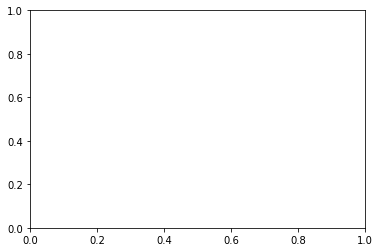

In [101]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')

In [54]:
embedding_df = pd.DataFrame(embedding)

In [59]:
print(embedding_df[0].min())
print(embedding_df[0].max())
print(embedding_df[1].min())
print(embedding_df[1].max())

-5.503086090087891
1.7559527158737183
-2.165020227432251
3.043438196182251


In [103]:
# Transformación de los embbeding a positivos
embedding_positive = embedding-embedding_df[0].min()
embedding_positive

array([[3.910143 , 7.4778743],
       [3.93804  , 5.9396358],
       [3.7401528, 5.486389 ],
       ...,
       [2.120136 , 4.0490603],
       [2.1481922, 6.1100335],
       [1.6514668, 6.033452 ]], dtype=float32)

In [112]:
text_colums_umap = pd.DataFrame(embedding_positive)

In [113]:
text_colums_umap.head()

,0,1
0,3.910143,7.477874
1,3.938040,5.939636
2,3.740153,5.486389
3,5.415134,7.452929
4,2.083198,7.512875


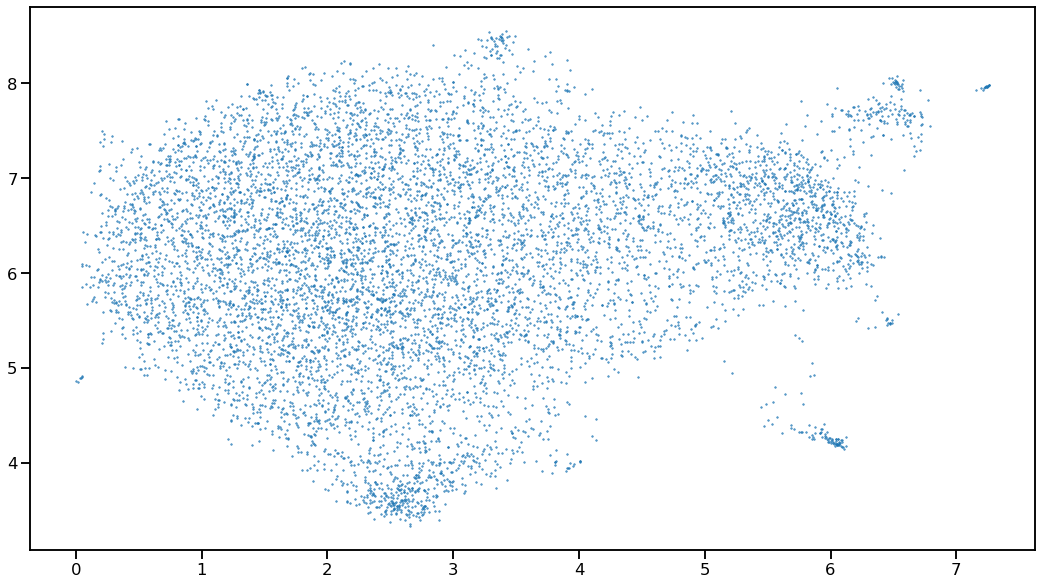

In [110]:
plt.figure(figsize=(18,10))
plt.scatter(embedding_positive[:, 0], embedding_positive[:, 1], s=0.5, cmap='Spectral')


sns.set_context("talk")
plt.savefig("images/output_images/embedding_positive.png")
plt.show()

### Get new numerical columns

I will get the original dataframe with its posts lengths and variances, dummies from every type and dummies on every type dimension axis.

In [176]:
def var_row(row):
    lst = []
    for word in row.split("|||"):
        lst.append(len(word.split()))
    return np.var(lst)

mbti_df["words_per_comment"] = mbti_df["posts"].apply(lambda x: len(x.split())/50)
mbti_df["variance_of_word_counts"] = mbti_df["posts"].apply(lambda x: var_row(x))

In [177]:
type_dummies = pd.get_dummies(mbti_df["type"])
mbti_df.drop(["posts"], axis=1, inplace=True)
mbti_df = pd.concat([mbti_df, type_dummies], axis=1,levels=None ,sort=False)

In [178]:
map1 = {"I": 0, "E": 1}
map2 = {"N": 0, "S": 1}
map3 = {"T": 0, "F": 1}
map4 = {"J": 0, "P": 1}
mbti_df["I-E"] = mbti_df["type"].astype(str).str[0]
mbti_df["I-E"] = mbti_df["I-E"].map(map1)
mbti_df["N-S"] = mbti_df["type"].astype(str).str[1]
mbti_df["N-S"] = mbti_df["N-S"].map(map2)
mbti_df["T-F"] = mbti_df["type"].astype(str).str[2]
mbti_df["T-F"] = mbti_df["T-F"].map(map3)
mbti_df["J-P"] = mbti_df["type"].astype(str).str[3]
mbti_df["J-P"] = mbti_df["J-P"].map(map4)

### Merge

I will merge umap results with the new numerical columns I created

In [179]:
mbti_df.drop(["type"], axis=1, inplace=True)
result = pd.concat([mbti_df, text_colums_umap], axis=1,levels=None ,sort=False)

In [204]:
result.to_csv("data/output_csv/result.csv")

In [203]:
result.head()

,words_per_comment,variance_of_word_counts,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP,I-E,N-S,T-F,J-P,0,1
0,11.12,135.2900,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,3.910143,7.477874
1,23.40,187.4756,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,3.938040,5.939636
2,16.72,180.6900,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,3.740153,5.486389
3,21.28,181.8324,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5.415134,7.452929
4,19.34,196.4576,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.083198,7.512875


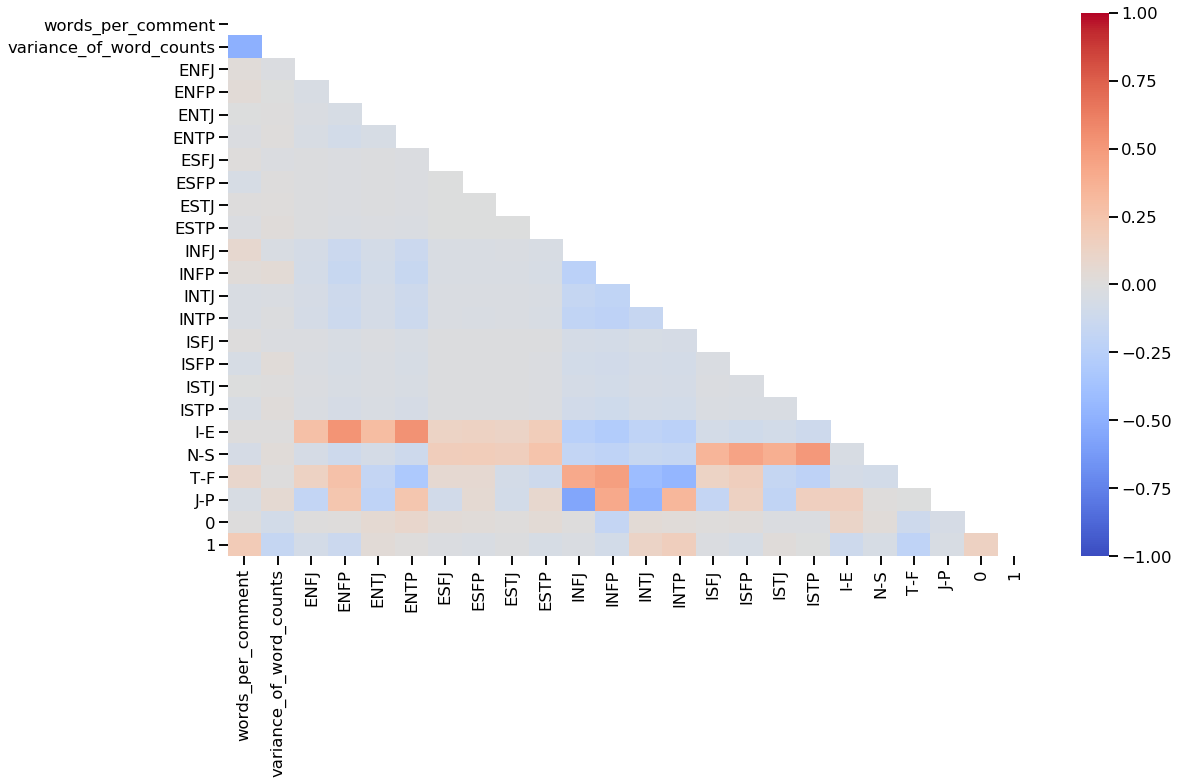

In [183]:
mask = np.triu(np.ones_like(result.corr(), dtype=np.bool))
plt.figure(figsize=(18,10))
sns.heatmap(result.corr(), mask=mask, cmap='coolwarm', vmin=-1, vmax=1) 
sns.set_context("talk")
plt.show()